In [ ]:
# ----------------------------------------
# 1. Mount Google Drive
# ----------------------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ----------------------------------------
# 2. Install necessary libraries
# ----------------------------------------
!pip install -q datasets
!pip install -q git+https://github.com/huggingface/transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Importing Libraries
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
from datasets import load_dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("gymprathap/Breast-Cancer-Ultrasound-Images-Dataset")

In [ ]:
# ----------------------------------------
# 3. Load the breast cancer dataset
# ----------------------------------------
# Load the breast cancer dataset from Hugging Face
dataset = load_dataset("nielsr/breast-cancer")

# Extract the train split
train_split = dataset["train"]

# Save images and masks locally for processing
image_dir = "/content/breast-cancer-dataset/images/"
label_dir = "/content/breast-cancer-dataset/labels/"
os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

for idx, example in enumerate(train_split):
    image = Image.fromarray(np.array(example["image"]))
    mask = Image.fromarray(np.array(example["label"]))
    image.save(os.path.join(image_dir, f"{idx}.png"))
    mask.save(os.path.join(label_dir, f"{idx}.png"))

print("Dataset images and labels saved locally.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/637 [00:00<?, ?B/s]

(…)-00000-of-00001-9cd7b7429038b476.parquet:   0%|          | 0.00/10.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130 [00:00<?, ? examples/s]

Dataset images and labels saved locally.


In [ ]:
# ----------------------------------------
# 4. Load the fine-tuned model and processor
# ----------------------------------------
# Specify the path where you saved the model
model_path = "/content/drive/MyDrive/SAM_shared_folder"

# Load the fine-tuned SAM model
sam_model = TFSamModel.from_pretrained(model_path)

# Load the corresponding processor
sam_processor = SamProcessor.from_pretrained(model_path)

print("Model and Processor loaded from Google Drive.")

All model checkpoint layers were used when initializing TFSamModel.

All the layers of TFSamModel were initialized from the model checkpoint at /content/drive/MyDrive/SAM_shared_folder.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


Model and Processor loaded from Google Drive.


In [ ]:
# ----------------------------------------
# 5. Define a helper to compute a bounding box from a mask
# ----------------------------------------
def get_bounding_box(ground_truth_map):
    """Extract a bounding box from the ground truth mask (non-zero values)."""
    y_indices, x_indices = np.where(ground_truth_map > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        # If there's no foreground, return a small box around the center
        H, W = ground_truth_map.shape
        cx, cy = W // 2, H // 2
        return [cx, cy, cx + 1, cy + 1]

    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    # Optionally expand bounding box a bit
    H, W = ground_truth_map.shape
    expand = 10  # expand bounding box by 10 pixels on each side
    x_min = max(0, x_min - expand)
    x_max = min(W, x_max + expand)
    y_min = max(0, y_min - expand)
    y_max = min(H, y_max + expand)

    return [x_min, y_min, x_max, y_max]

In [ ]:
# ----------------------------------------
# 6. Define IoU computation
# ----------------------------------------
def compute_iou(y_true, y_pred, threshold=0.5):
    """
    Compute the IoU (Jaccard Index) between y_true and y_pred.
    Assumes both are 2D masks (H x W).
    """
    # Binarize the predicted mask
    y_pred_bin = (y_pred >= threshold).astype(np.uint8)
    # Binarize the ground truth (in case it has multiple classes > 0)
    y_true_bin = (y_true > 0).astype(np.uint8)

    intersection = np.logical_and(y_true_bin, y_pred_bin).sum()
    union = np.logical_or(y_true_bin, y_pred_bin).sum()
    iou = intersection / (union + 1e-6)
    return iou

In [ ]:
# ----------------------------------------
# 7. Test / Inference on a single image
# ----------------------------------------
# Replace these with the paths to your test image and mask
test_image_path = os.path.join(image_dir, "0.png")
test_mask_path = os.path.join(label_dir, "0.png")

# Check that your files exist
assert os.path.exists(test_image_path), f"Image {test_image_path} not found."
assert os.path.exists(test_mask_path), f"Label {test_mask_path} not found."

# Load image and mask
image = Image.open(test_image_path).convert("RGB")
ground_truth_mask = np.array(Image.open(test_mask_path))

# Get bounding box from the ground-truth mask
prompt_box = get_bounding_box(ground_truth_mask)

# Process inputs for the SAM model
inputs = sam_processor(
    images=image,
    input_boxes=[[prompt_box]],
    return_tensors="tf"
)

# Run the model in inference mode
outputs = sam_model(
    pixel_values=inputs["pixel_values"],
    input_boxes=inputs["input_boxes"],
    multimask_output=False,
    training=False
)

# Extract and post-process the predicted mask
predicted_mask_logits = outputs.pred_masks  # shape: (batch_size, num_masks=1, height, width)
predicted_mask = tf.sigmoid(predicted_mask_logits)[0, 0].numpy()  # Apply sigmoid to get probabilities


In [ ]:
# ----------------------------------------
# 8. Define Dice Loss
# ----------------------------------------
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice loss between ground truth and predicted masks.

    Args:
        y_true: Ground truth mask
        y_pred: Predicted mask probabilities
        smooth: Smoothing factor to avoid division by zero

    Returns:
        Dice loss value
    """
    # Flatten the tensors
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    # Calculate Dice coefficient
    dice_coefficient = (2. * intersection + smooth) / (union + smooth)

    # Return Dice loss
    return 1 - dice_coefficient

# ----------------------------------------
# Calculate Dice Loss for the prediction
# ----------------------------------------
# Convert ground truth mask to binary and the correct shape
ground_truth_mask_binary = (ground_truth_mask > 0).astype(np.float32)
ground_truth_mask_tensor = tf.convert_to_tensor(ground_truth_mask_binary, dtype=tf.float32)

# Convert predicted mask to tensor
predicted_mask_tensor = tf.convert_to_tensor(predicted_mask, dtype=tf.float32)

# Calculate Dice loss
dice_loss_value = dice_loss(ground_truth_mask_tensor, predicted_mask_tensor)
print(f"Dice Loss: {dice_loss_value:.4f}")

Dice Loss: 0.1105


In [ ]:
# ----------------------------------------
# 9. Compute IoU
# ----------------------------------------
iou_score = compute_iou(ground_truth_mask, predicted_mask, threshold=0.5)
print(f"IoU (threshold=0.5): {iou_score:.4f}")

IoU (threshold=0.5): 0.8256


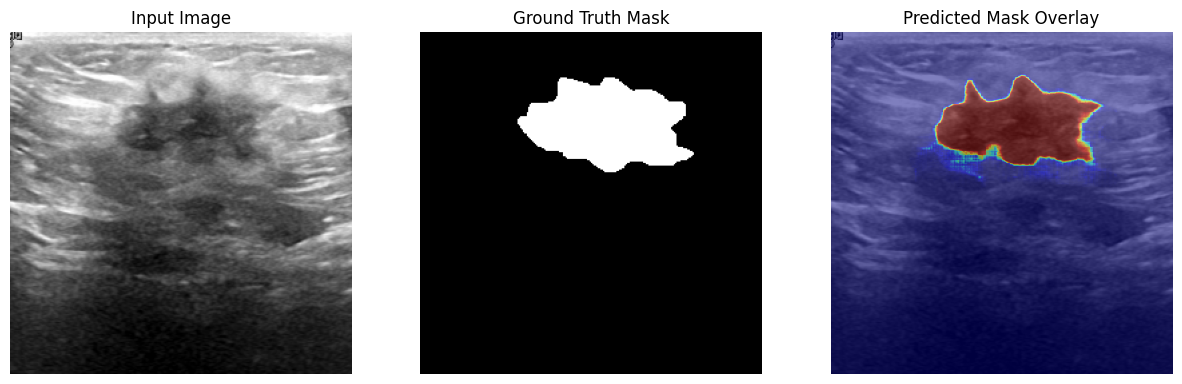

In [ ]:
# ----------------------------------------
# 10. Visualize the results
# ----------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(ground_truth_mask, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(image)
axes[2].imshow(np.squeeze(predicted_mask), cmap="jet", alpha=0.5)
axes[2].set_title("Predicted Mask Overlay")
axes[2].axis("off")

plt.show()

In [ ]:
sam_model = TFSamModel.from_pretrained("facebook/sam-vit-large")
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


In [ ]:
# ----------------------------------------
# 5. Define a helper to compute a bounding box from a mask
# ----------------------------------------
def get_bounding_box(ground_truth_map):
    """Extract a bounding box from the ground truth mask (non-zero values)."""
    y_indices, x_indices = np.where(ground_truth_map > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        # If there's no foreground, return a small box around the center
        H, W = ground_truth_map.shape
        cx, cy = W // 2, H // 2
        return [cx, cy, cx + 1, cy + 1]

    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    # Optionally expand bounding box a bit
    H, W = ground_truth_map.shape
    expand = 10  # expand bounding box by 10 pixels on each side
    x_min = max(0, x_min - expand)
    x_max = min(W, x_max + expand)
    y_min = max(0, y_min - expand)
    y_max = min(H, y_max + expand)

    return [x_min, y_min, x_max, y_max]

In [ ]:
# ----------------------------------------
# 6. Define IoU computation
# ----------------------------------------
def compute_iou(y_true, y_pred, threshold=0.5):
    """
    Compute the IoU (Jaccard Index) between y_true and y_pred.
    Assumes both are 2D masks (H x W).
    """
    # Binarize the predicted mask
    y_pred_bin = (y_pred >= threshold).astype(np.uint8)
    # Binarize the ground truth (in case it has multiple classes > 0)
    y_true_bin = (y_true > 0).astype(np.uint8)

    intersection = np.logical_and(y_true_bin, y_pred_bin).sum()
    union = np.logical_or(y_true_bin, y_pred_bin).sum()
    iou = intersection / (union + 1e-6)
    return iou

In [ ]:
# ----------------------------------------
# 7. Test / Inference on a single image
# ----------------------------------------
# Replace these with the paths to your test image and mask
test_image_path = os.path.join(image_dir, "0.png")
test_mask_path = os.path.join(label_dir, "0.png")

# Check that your files exist
assert os.path.exists(test_image_path), f"Image {test_image_path} not found."
assert os.path.exists(test_mask_path), f"Label {test_mask_path} not found."

# Load image and mask
image = Image.open(test_image_path).convert("RGB")
ground_truth_mask = np.array(Image.open(test_mask_path))

# Get bounding box from the ground-truth mask
prompt_box = get_bounding_box(ground_truth_mask)

# Process inputs for the SAM model
inputs = sam_processor(
    images=image,
    input_boxes=[[prompt_box]],
    return_tensors="tf"
)

# Run the model in inference mode
outputs = sam_model(
    pixel_values=inputs["pixel_values"],
    input_boxes=inputs["input_boxes"],
    multimask_output=False,
    training=False
)

# Extract and post-process the predicted mask
predicted_mask_logits = outputs.pred_masks  # shape: (batch_size, num_masks=1, height, width)
predicted_mask = tf.sigmoid(predicted_mask_logits)[0, 0].numpy()  # Apply sigmoid to get probabilities


In [ ]:
# ----------------------------------------
# 8. Define Dice Loss
# ----------------------------------------
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice loss between ground truth and predicted masks.

    Args:
        y_true: Ground truth mask
        y_pred: Predicted mask probabilities
        smooth: Smoothing factor to avoid division by zero

    Returns:
        Dice loss value
    """
    # Flatten the tensors
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    # Calculate Dice coefficient
    dice_coefficient = (2. * intersection + smooth) / (union + smooth)

    # Return Dice loss
    return 1 - dice_coefficient

# ----------------------------------------
# Calculate Dice Loss for the prediction
# ----------------------------------------
# Convert ground truth mask to binary and the correct shape
ground_truth_mask_binary = (ground_truth_mask > 0).astype(np.float32)
ground_truth_mask_tensor = tf.convert_to_tensor(ground_truth_mask_binary, dtype=tf.float32)

# Convert predicted mask to tensor
predicted_mask_tensor = tf.convert_to_tensor(predicted_mask, dtype=tf.float32)

# Calculate Dice loss
dice_loss_value = dice_loss(ground_truth_mask_tensor, predicted_mask_tensor)
print(f"Dice Loss: {dice_loss_value:.4f}")

Dice Loss: 0.1793


In [ ]:
# ----------------------------------------
# 9. Compute IoU
# ----------------------------------------
iou_score = compute_iou(ground_truth_mask, predicted_mask, threshold=0.5)
print(f"IoU (threshold=0.5): {iou_score:.4f}")

IoU (threshold=0.5): 0.6976


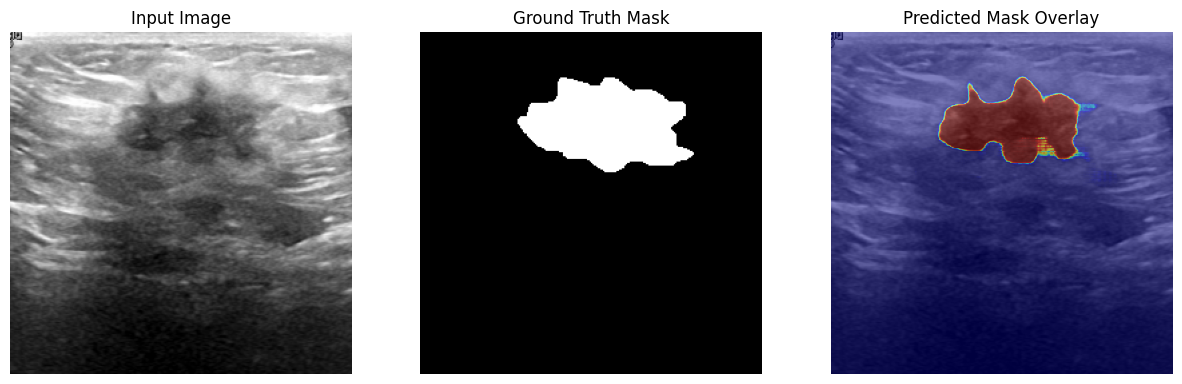

In [ ]:
# ----------------------------------------
# 10. Visualize the results
# ----------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(ground_truth_mask, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(image)
axes[2].imshow(np.squeeze(predicted_mask), cmap="jet", alpha=0.5)
axes[2].set_title("Predicted Mask Overlay")
axes[2].axis("off")

plt.show()

In [ ]:
# Environment Setup
# Install necessary libraries
!pip install -q datasets
!pip install -q git+https://github.com/huggingface/transformers

# Importing Libraries
from tensorflow import keras
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
import glob
import os
from datasets import load_dataset

# Enable TensorFlow's numpy behavior
np_config.enable_numpy_behavior()

# Load the breast cancer dataset from Hugging Face
dataset = load_dataset("nielsr/breast-cancer")

# Extract the train split
train_split = dataset["train"]

# Save images and masks locally for processing
image_dir = "/content/breast-cancer-dataset/images/"
label_dir = "/content/breast-cancer-dataset/labels/"
os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

for idx, example in enumerate(train_split):
    image = Image.fromarray(np.array(example["image"]))
    mask = Image.fromarray(np.array(example["label"]))
    image.save(os.path.join(image_dir, f"{idx}.png"))
    mask.save(os.path.join(label_dir, f"{idx}.png"))

print("Dataset images and labels saved locally.")

# Model Initialization
sam_model = TFSamModel.from_pretrained("facebook/sam-vit-large")
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

# Freeze specific layers
for layer in sam_model.layers:
    if layer.name in ["vision_encoder", "prompt_encoder"]:
        layer.trainable = False

# Define the DataGenerator class for processing images and masks
class DataGenerator:
    def __init__(self, dataset_path, processor, image_paths, label_paths):
        self.dataset_path = dataset_path
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.processor = processor

    def __call__(self):
        for image_path, label_path in zip(self.image_paths, self.label_paths):
            image = np.array(Image.open(image_path))
            ground_truth_mask = np.array(Image.open(label_path))
            prompt = self.get_bounding_box(ground_truth_mask)
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="np")
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            inputs["ground_truth_mask"] = ground_truth_mask
            yield inputs

    def get_bounding_box(self, ground_truth_map):
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        return [x_min, y_min, x_max, y_max]

# Dataset Paths
dataset_path = "/content/breast-cancer-dataset"
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))[1:]
label_paths = sorted(glob.glob(os.path.join(label_dir, "*.png")))[1:]

# Create TensorFlow dataset
output_signature = {
    "pixel_values": tf.TensorSpec(shape=(3, None, None), dtype=tf.float32),
    "original_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "reshaped_input_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "input_boxes": tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    "ground_truth_mask": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
}
train_dataset_gen = DataGenerator(dataset_path, sam_processor, image_paths, label_paths)
train_ds = tf.data.Dataset.from_generator(
    train_dataset_gen, output_signature=output_signature
).cache().shuffle(40).batch(2).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define DICE Loss Function
def dice_loss_func(y_true, y_pred, smooth=1e-5):
    y_pred = tf.sigmoid(y_pred)
    reduce_axis = list(range(2, len(y_pred.shape)))
    intersection = tf.reduce_sum(y_true * y_pred, axis=reduce_axis)
    ground_o = tf.reduce_sum(tf.math.pow(y_true, 2), axis=reduce_axis)
    pred_o = tf.reduce_sum(tf.math.pow(y_pred, 2), axis=reduce_axis)
    loss = 1.0 - (2.0 * intersection + smooth) / (ground_o + pred_o + smooth)
    return tf.reduce_mean(loss)

# Initialize optimizer and gradient accumulation
opt = keras.optimizers.Adam(learning_rate=1e-5)
accumulation_steps = 2  # Accumulate gradients over 2 steps

@tf.function
def train_step_func(inputs, accum_grads):
    with tf.GradientTape() as tape:
        outputs = sam_model(
            pixel_values=inputs["pixel_values"],
            input_boxes=inputs["input_boxes"],
            multimask_output=False,
            training=True,
        )
        predicted_masks = tf.squeeze(outputs.pred_masks, 1)
        ground_truth_masks = tf.cast(inputs["ground_truth_mask"], tf.float32)
        loss = dice_loss_func(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        grads = tape.gradient(loss, sam_model.trainable_variables)

    # Accumulate gradients
    new_accum_grads = []
    for g, ag in zip(grads, accum_grads):
        if g is not None:
            g = tf.convert_to_tensor(g) if isinstance(g, tf.IndexedSlices) else g
            new_accum_grads.append(g + (ag if ag is not None else tf.zeros_like(g)))
        else:
            new_accum_grads.append(ag)
    return loss, new_accum_grads

# Training loop
for epoch in range(5):
    epoch_loss = []
    accum_grads = [None] * len(sam_model.trainable_variables)
    step_count = 0

    for inputs in train_ds:
        loss, accum_grads = train_step_func(inputs, accum_grads)
        epoch_loss.append(loss.numpy())
        step_count += 1

        if step_count % accumulation_steps == 0:
            # Apply accumulated gradients
            opt.apply_gradients(zip(accum_grads, sam_model.trainable_variables))
            accum_grads = [None] * len(sam_model.trainable_variables)  # Reset accumulators

    # Apply remaining gradients
    if step_count % accumulation_steps != 0:
        opt.apply_gradients(zip(accum_grads, sam_model.trainable_variables))

    print(f"Epoch {epoch + 1}: Training Loss = {np.mean(epoch_loss)}")

# Save the fine-tuned model
output_dir = "/content/drive/MyDrive/SAM_shared_folder"
os.makedirs(output_dir, exist_ok=True)
sam_model.save_pretrained(output_dir)
sam_processor.save_pretrained(output_dir)
print(f"Fine-tuned model saved at {output_dir}")


Dataset images and labels saved locally.


All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


Epoch 1: Training Loss = 0.14869971573352814


Epoch 2: Training Loss = 0.12080703675746918


Epoch 3: Training Loss = 0.10982788354158401


Epoch 4: Training Loss = 0.10310754179954529


Epoch 5: Training Loss = 0.09755291044712067
Fine-tuned model saved at /content/drive/MyDrive/SAM_shared_folder
